In [ ]:
%pip install mlxtend --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [ ]:
# set some parameters
num_files = 1
# I recommend set num_filter to be about 10 to 20% of the original # variables
num_filter = 300
# I recommend set num_wrapper to be about 50, then look for a saturation of the model performance as variables are added
# Then you can run it again with num_wrapper just a bit above this saturation point, not more than about twice this saturation number
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
good_label = 0
bad_label = 1

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.chdir("/content/drive/MyDrive/DSO562")

In [ ]:
data = pd.read_csv('candidate_variables.csv')

In [ ]:
data.head()

,Recnum,Fraud,Dow_Risk,state_risk,benford_Cardnum,benford_Merchnum,Cardnum_day_since,Cardnum_count_0,Cardnum_avg_0,Cardnum_max_0,...,Merchnum_desc_count_1_by_60_sq,Card_Merchnum_desc_count_0_by_7_sq,Card_Merchnum_desc_count_0_by_14_sq,Card_Merchnum_desc_count_0_by_30_sq,Card_Merchnum_desc_count_0_by_60_sq,Card_Merchnum_desc_count_1_by_7_sq,Card_Merchnum_desc_count_1_by_14_sq,Card_Merchnum_desc_count_1_by_30_sq,Card_Merchnum_desc_count_1_by_60_sq,amount_cat
0,1,0,0.025994,0.007970,1.000894,1.000894,1461.0,1,3.62,3.62,...,0.000278,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1
1,2,0,0.025994,0.003304,1.000894,1.000894,1461.0,1,31.42,31.42,...,0.000278,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,2
2,3,0,0.025994,0.017282,1.000894,1.000894,1461.0,1,178.49,178.49,...,0.000278,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,3
3,4,0,0.025994,0.007970,1.000894,1.010684,1461.0,1,3.62,3.62,...,0.000278,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1
4,5,0,0.025994,0.007970,1.010684,1.031246,0.0,2,3.62,3.62,...,0.000278,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1


In [ ]:
#drop Benford's law variables
data = data.drop(columns=['benford_Cardnum','benford_Merchnum'])
data.head()

,Recnum,Fraud,Dow_Risk,state_risk,Cardnum_day_since,Cardnum_count_0,Cardnum_avg_0,Cardnum_max_0,Cardnum_med_0,Cardnum_total_0,...,Merchnum_desc_count_1_by_60_sq,Card_Merchnum_desc_count_0_by_7_sq,Card_Merchnum_desc_count_0_by_14_sq,Card_Merchnum_desc_count_0_by_30_sq,Card_Merchnum_desc_count_0_by_60_sq,Card_Merchnum_desc_count_1_by_7_sq,Card_Merchnum_desc_count_1_by_14_sq,Card_Merchnum_desc_count_1_by_30_sq,Card_Merchnum_desc_count_1_by_60_sq,amount_cat
0,1,0,0.025994,0.007970,1461.0,1,3.62,3.62,3.62,3.62,...,0.000278,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1
1,2,0,0.025994,0.003304,1461.0,1,31.42,31.42,31.42,31.42,...,0.000278,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,2
2,3,0,0.025994,0.017282,1461.0,1,178.49,178.49,178.49,178.49,...,0.000278,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,3
3,4,0,0.025994,0.007970,1461.0,1,3.62,3.62,3.62,3.62,...,0.000278,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1
4,5,0,0.025994,0.007970,0.0,2,3.62,3.62,3.62,7.24,...,0.000278,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1


## Run a filter on all the files

In [ ]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    df = data
    df = df.set_index(index_name)
    #df = df[df.index < 84161] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 3477] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()

        if(i > 0):
            goods = goods.loc[goods_keep]

    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1])
    print(filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)

    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)

    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
                       variable  filter score
0                         Fraud      1.000000
419           card_zip3_total_7      0.676539
227            card_zip_total_7      0.666825
410           card_zip3_total_3      0.661258
428          card_zip3_total_14      0.659224
218            card_zip_total_3      0.653235
236           card_zip_total_14      0.652226
163          card_merch_total_7      0.637699
245           card_zip_total_30      0.636965
154          card_merch_total_3      0.631776
417             card_zip3_max_7      0.630844
172         card_merch_total_14      0.630024
437          card_zip3_total_30      0.629844
426            card_zip3_max_14      0.629411
234             card_zip_max_14      0.627835
225              card_zip_max_7      0.625021
243             card_zip_max_30      0.623987
483      Card_Merchdesc_total_7      0.621799
611  Card_Merchnum_desc_total_7      0.618043
254           card_

In [ ]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [ ]:
filter_score.head(30)


,variable,filter score
0,Fraud,1.000000
1,card_zip3_total_7,0.676539
2,card_zip_total_7,0.666825
3,card_zip3_total_3,0.661258
4,card_zip3_total_14,0.659224
5,card_zip_total_3,0.653235
6,card_zip_total_14,0.652226
7,card_merch_total_7,0.637699
8,card_zip_total_30,0.636965
9,card_merch_total_3,0.631776


In [ ]:
filter_score.tail(10)

,variable,filter score
1412,card_merch_unique_count_for_zip3_7,0.000958
1413,Card_Merchdesc_unique_count_for_zip3_3,0.000892
1414,card_merch_unique_count_for_zip3_3,0.000827
1415,Card_Merchnum_desc_unique_count_for_zip3_7,0.000805
1416,Card_Merchdesc_unique_count_for_zip3_1,0.000707
1417,card_merch_unique_count_for_zip3_1,0.000697
1418,Card_Merchnum_desc_unique_count_for_zip3_3,0.000675
1419,Merchnum_desc_unique_count_for_zip3_3,0.000667
1420,Card_Merchnum_desc_unique_count_for_zip3_1,0.000588
1421,card_merch_unique_count_for_Cardnum_1,0.000000


In [ ]:
filter_score.shape

(1422, 2)

In [ ]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['card_zip3_total_7', 'card_zip_total_7', 'card_zip3_total_3', 'card_zip3_total_14', 'card_zip_total_3', 'card_zip_total_14', 'card_merch_total_7', 'card_zip_total_30', 'card_merch_total_3', 'card_zip3_max_7', 'card_merch_total_14', 'card_zip3_total_30', 'card_zip3_max_14', 'card_zip_max_14', 'card_zip_max_7', 'card_zip_max_30', 'Card_Merchdesc_total_7', 'Card_Merchnum_desc_total_7', 'card_zip_total_60', 'card_zip3_total_1', 'card_merch_total_30', 'card_zip3_max_30', 'Card_Merchdesc_total_14', 'Card_Merchnum_desc_total_14', 'card_zip_total_1', 'Card_Merchdesc_total_3', 'card_zip3_total_60', 'Card_Merchnum_desc_total_3', 'card_zip3_max_3', 'Card_Merchdesc_total_30', 'Card_Merchnum_desc_total_30', 'card_merch_max_14', 'card_zip_max_60', 'card_merch_max_30', 'Card_Merchdesc_max_14', 'card_merch_max_7', 'Card_Merchnum_desc_max_14', 'Card_Merchdesc_max_30', 'Card_Merchdesc_max_7', 'card_zip_max_3', 'Card_Merchnum_desc_max_30', 'card_merch_total_60', 'Card_Merchnum_desc_max_7',

In [ ]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,card_zip3_total_7,card_zip_total_7,card_zip3_total_3,card_zip3_total_14,card_zip_total_3,card_zip_total_14,card_merch_total_7,card_zip_total_30,card_merch_total_3,card_zip3_max_7,...,zip3_med_1,Merchnum_variability_avg_30,zip3_avg_3,card_zip_count_7,merch_zip_variability_avg_30,Cardnum_count_14,zip3_actual/max_14,card_zip3_actual/toal_3,Merchnum_desc_variability_med_30,zip3_actual/med_7
Recnum,,,,,,,,,,,,,,,,,,,,,
3477,59.23,59.23,59.23,59.23,59.23,59.23,59.23,59.23,59.23,59.23,...,168.53,283.525000,297.020000,1,283.525000,6,0.042705,1.000000,144.570,0.329110
3478,807.76,807.76,807.76,807.76,807.76,807.76,807.76,807.76,807.76,807.76,...,327.68,-299.973158,450.003333,1,-299.973158,1,0.352889,1.000000,-565.475,3.634956
3479,1902.00,1902.00,1902.00,1902.00,1902.00,1902.00,1902.00,1902.00,1902.00,1491.00,...,233.83,152.373056,480.643333,2,152.373056,5,0.166061,0.216088,-98.750,1.409658
3480,35.48,35.48,35.48,35.48,35.48,35.48,35.48,35.48,35.48,6.62,...,4.37,1.878635,10.059706,9,1.878635,9,0.003785,0.102029,0.750,0.967914
3481,435.85,435.85,273.03,624.64,273.03,624.64,419.05,624.64,260.03,15.40,...,4.37,1.125500,10.026433,93,1.125500,141,0.004569,0.016006,0.000,1.168449


In [ ]:
df_keep.shape

(92927, 300)

In [ ]:
Y.head()

,Fraud
Recnum,
3477,0
3478,0
3479,0
3480,0
3481,0


In [ ]:
Y = Y.values
Y_save = Y.copy()

In [ ]:
# Y = np.array(Y)
X = df_keep
print(Y)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [ ]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:03:43.723910


In [ ]:
print(X.shape,Y.shape)

(92927, 300) (92927, 1)


In [ ]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [ ]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods =

In [ ]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud

## Run a wrapper on the remaining top variables

In [ ]:
%%time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# If you're doing forward selection it's enough to stop at num_wrapper variables.
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.

# I can't figure out how to get rid of this annoying warning! I don't know what I'm doing wrong...

nfeatures = len(X.columns)
#clf = RandomForestClassifier(n_estimators=5,max_depth = 15, min_samples_leaf = 3) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=20,num_leaves=4) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=4,n_jobs=-1) # use for forward selection
#sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for backward selection
sfs.fit(X,Y)

CPU times: user 31.8 s, sys: 4.88 s, total: 36.7 s
Wall time: 19min 55s


SequentialFeatureSelector(cv=4,
                          estimator=LGBMClassifier(n_estimators=20,
                                                   num_leaves=4),
                          k_features=(20, 20), n_jobs=-1,
                          scoring=<function fdr at 0x7fef993f4c10>)

In [ ]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:26:39.203830


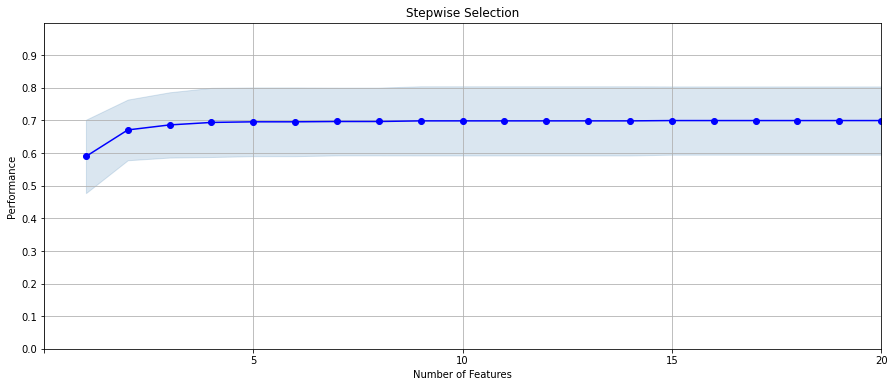

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()

In [ ]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [ ]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))
#You might also need this following line. It converts a list to a string
        ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]

In [ ]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(10,)","[0.6666666666666666, 0.5648854961832062, 0.709...",0.589775,"(card_merch_total_14,)",0.180297,0.112476,0.064938,1.0,card_merch_total_14
2,"(10, 12)","[0.7586206896551724, 0.6564885496183206, 0.744...",0.671072,"(card_merch_total_14, card_zip3_max_14)",0.149088,0.093007,0.053698,2.0,card_zip3_max_14
3,"(10, 12, 287)","[0.8084291187739464, 0.6564885496183206, 0.740...",0.686401,"(card_merch_total_14, card_zip3_max_14, Card_M...",0.160446,0.100092,0.057788,3.0,Card_Merchdesc_count_7
4,"(10, 12, 195, 287)","[0.8084291187739464, 0.6526717557251909, 0.774...",0.694035,"(card_merch_total_14, card_zip3_max_14, merch_...",0.169979,0.106039,0.061222,4.0,merch_zip_max_7
5,"(10, 12, 110, 195, 287)","[0.8084291187739464, 0.6603053435114504, 0.774...",0.695943,"(card_merch_total_14, card_zip3_max_14, Card_M...",0.168865,0.105344,0.060821,5.0,Card_Merchnum_desc_avg_7
6,"(10, 12, 62, 110, 195, 287)","[0.8084291187739464, 0.6603053435114504, 0.774...",0.695943,"(card_merch_total_14, card_zip3_max_14, Card_M...",0.168865,0.105344,0.060821,6.0,Card_Merchnum_desc_max_1
7,"(10, 12, 59, 62, 110, 195, 287)","[0.8084291187739464, 0.6603053435114504, 0.774...",0.696901,"(card_merch_total_14, card_zip3_max_14, Card_M...",0.166601,0.103932,0.060005,7.0,Card_Merchdesc_max_1
8,"(10, 12, 54, 59, 62, 110, 195, 287)","[0.8084291187739464, 0.6603053435114504, 0.774...",0.696901,"(card_merch_total_14, card_zip3_max_14, Card_M...",0.166601,0.103932,0.060005,8.0,Card_Merchnum_desc_max_3
9,"(10, 12, 54, 59, 62, 110, 195, 199, 287)","[0.8160919540229885, 0.6603053435114504, 0.774...",0.698817,"(card_merch_total_14, card_zip3_max_14, Card_M...",0.169948,0.10602,0.06121,9.0,merch_zip_med_0
10,"(10, 12, 54, 59, 62, 67, 110, 195, 199, 287)","[0.8160919540229885, 0.6603053435114504, 0.774...",0.698817,"(card_merch_total_14, card_zip3_max_14, Card_M...",0.169948,0.10602,0.06121,10.0,card_zip_max_0


In [ ]:
ordered_vars_FS.to_csv('Wrapper_selection_info.csv', index=False)

In [ ]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

1          card_merch_total_14
2             card_zip3_max_14
3       Card_Merchdesc_count_7
4              merch_zip_max_7
5     Card_Merchnum_desc_avg_7
6     Card_Merchnum_desc_max_1
7         Card_Merchdesc_max_1
8     Card_Merchnum_desc_max_3
9              merch_zip_med_0
10              card_zip_max_0
11            card_merch_max_0
12        Card_Merchdesc_max_0
13    Card_Merchnum_desc_max_0
14            card_merch_avg_7
15              card_zip_med_3
16    Card_Merchnum_desc_avg_3
17             card_zip3_avg_1
18            card_merch_avg_1
19        Card_Merchdesc_avg_1
20    Card_Merchnum_desc_avg_1
Name: variable name, dtype: object

In [ ]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

KeyError: ignored

In [ ]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

""
variable
card_merch_total_14
card_zip3_max_14
Card_Merchdesc_count_7
merch_zip_max_7
Card_Merchnum_desc_avg_7


In [ ]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')

In [ ]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted.head(20)

,wrapper order,variable,filter score
0,1,card_merch_total_14,0.630024
1,2,card_zip3_max_14,0.629411
2,3,Card_Merchdesc_count_7,0.366833
3,4,merch_zip_max_7,0.480074
4,5,Card_Merchnum_desc_avg_7,0.519332
5,6,Card_Merchnum_desc_max_1,0.560858
6,7,Card_Merchdesc_max_1,0.565138
7,8,Card_Merchnum_desc_max_3,0.576777
8,9,merch_zip_med_0,0.471049
9,10,card_zip_max_0,0.544058


In [ ]:
vars_keep_sorted.head(20)

,wrapper order,variable,filter score
0,1,card_merch_total_14,0.630024
1,2,card_zip3_max_14,0.629411
2,3,Card_Merchdesc_count_7,0.366833
3,4,merch_zip_max_7,0.480074
4,5,Card_Merchnum_desc_avg_7,0.519332
5,6,Card_Merchnum_desc_max_1,0.560858
6,7,Card_Merchdesc_max_1,0.565138
7,8,Card_Merchnum_desc_max_3,0.576777
8,9,merch_zip_med_0,0.471049
9,10,card_zip_max_0,0.544058


In [ ]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['card_merch_total_14',
 'card_zip3_max_14',
 'Card_Merchdesc_count_7',
 'merch_zip_max_7',
 'Card_Merchnum_desc_avg_7',
 'Card_Merchnum_desc_max_1',
 'Card_Merchdesc_max_1',
 'Card_Merchnum_desc_max_3',
 'merch_zip_med_0',
 'card_zip_max_0',
 'card_merch_max_0',
 'Card_Merchdesc_max_0',
 'Card_Merchnum_desc_max_0',
 'card_merch_avg_7',
 'card_zip_med_3',
 'Card_Merchnum_desc_avg_3',
 'card_zip3_avg_1',
 'card_merch_avg_1',
 'Card_Merchdesc_avg_1',
 'Card_Merchnum_desc_avg_1',
 'Recnum',
 'Fraud']

In [ ]:
filter_score

,filter score
variable,
card_zip3_total_7,0.676539
card_zip_total_7,0.666825
card_zip3_total_3,0.661258
card_zip3_total_14,0.659224
card_zip_total_3,0.653235
...,...
card_merch_unique_count_for_zip3_1,0.000697
Card_Merchnum_desc_unique_count_for_zip3_3,0.000675
Merchnum_desc_unique_count_for_zip3_3,0.000667


In [ ]:
%%time
df = pd.read_csv('candidate_variables.csv')
df.shape

CPU times: user 19.1 s, sys: 1.65 s, total: 20.8 s
Wall time: 21.3 s


(96397, 1424)

In [ ]:
df_keep = df.filter(vars_keep_list, axis=1)
# df_keep = df[df.index.isin(vars_keep_list)]
print(df_keep.shape)

(96397, 22)


In [ ]:
df_keep.to_csv('final.csv',index=False)

In [ ]:
print("duration: ", dt.datetime.now() - start_time)

duration:  0:36:27.663681
